# Adversarie Attack on Fashion MNIST

Este notebook experimenta la creación de adversaries examples creados en un modelo para luego observar como opera la tranferibilidad de estas imagenes para probocar una clasificación fallida en otros modelo. 

In [2]:

# import the needed packages
import os
import time
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow as tf
from tensorflow import keras
from pylab import *
from numpy.random import seed
import matplotlib as mpl
import numpy as np

# Con sed hacemos reproducible algunos de los resultados
seed(1)


Configuracion necesaria para ejecucción en GPU con tarjeta grafica Nvidia GTX 1650 y para permitir uso de memoria

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Importamos las imagenes a procesar con keras.  
Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

Matriz con mapeo de clasificaciones

In [5]:
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

In [6]:
# Variables para mostrar resuldatosm imagenes
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

Las imagenes son en escala de grises tamaño 28x28. Visualizamos algunas imagenes:

In [7]:
# Agregamos una dimensión a los datos
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

Normalizamos las imagenes

In [8]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Nombre corto para clase ImageDataGenerator

In [9]:
ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

Definimos una funcion para la visualización de graficos

In [10]:
#normalize
imgdatagen = ImageDataGenerator(
    rescale = 1/255., 
 #   validation_split = 0.2,
)

Funcion para generar graficos comparativos y recta a maximo accuracy de test

Hiperparametros

In [11]:
epoch=15
batch_size = 32
height, width = (28,28)
steps_per_epoch = 1875 #60000/batch_size
learning_rate = 0.001


## MODEL_01: Modelo sustituto
Nuestro modelo base, red convolutiva con funciones relu 

In [14]:
model_01 = tf.keras.Sequential()
# Must define the input shape in the first layer of the neural network
model_01.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1))) 
model_01.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_01.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model_01.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model_01.add(tf.keras.layers.Flatten())
model_01.add(tf.keras.layers.Dense(124, activation='relu'))
model_01.add(tf.keras.layers.Dense(10, activation='softmax'))
# Take a look at the model summary
model_01.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 124)               194556    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [15]:

model_01.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [16]:
start_time = time.time()
history_01 = model_01.fit(
    x_train,y_train,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 17s 277us/sample - loss: 0.5108 - acc: 0.8164 - val_loss: 0.3869 - val_acc: 0.8628
Epoch 2/15
60000/60000 [==============================] - 17s 282us/sample - loss: 0.3493 - acc: 0.8759 - val_loss: 0.3370 - val_acc: 0.8815
Epoch 3/15
60000/60000 [==============================] - 17s 289us/sample - loss: 0.3075 - acc: 0.8890 - val_loss: 0.3132 - val_acc: 0.8848
Epoch 4/15
60000/60000 [==============================] - 17s 288us/sample - loss: 0.2789 - acc: 0.8991 - val_loss: 0.3069 - val_acc: 0.8904
Epoch 5/15
60000/60000 [==============================] - 20s 333us/sample - loss: 0.2584 - acc: 0.9062 - val_loss: 0.2958 - val_acc: 0.8918
Epoch 6/15
60000/60000 [==============================] - 22s 366us/sample - loss: 0.2409 - acc: 0.9124 - val_loss: 0.2700 - val_acc: 0.9017
Epoch 7/15
60000/60000 [==============================] - 23s 383us/sample - loss: 0.2246 - acc: 0.9181 

In [17]:
# serialize weights to HDF5
model_01.save_weights("fashion_model01.h5")

# Adversarie example

In [18]:
# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  result = np.where(probs[0] == np.amax(probs[0]))
  max_index = result[0][0]
  probabilidad=probs[0][max_index]
  label = fashion_mnist_labels[max_index] 
  #return  str(label) + " con probabilidad: " + str(probabilidad)
  return  "",label, probabilidad


In [19]:
index_image=995 #997 coat
image=x_test[index_image]
image_index_class = y_test[index_image]
image_tf = tf.convert_to_tensor(image, dtype=tf.float32)
#plt.imshow(np.squeeze(image))
#print(fashion_mnist_labels[image_index_class])

In [20]:
image_tf_a = image_tf[None, ...]
image_probs = model_01.predict(image_tf_a)

In [21]:
plt.figure()
plt.imshow(np.squeeze(image_tf_a[0]))
_, image_cla ss, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

SyntaxError: invalid syntax (<ipython-input-21-171e57ef45c1>, line 3)

In [22]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model_01(input_image)
    loss = loss_object(input_label, prediction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [23]:

label = tf.one_hot(image_index_class, image_probs.shape[-1]) #image_probs.shape[-1] = 1.000
label.shape

TensorShape([10])

In [24]:
label = tf.reshape(label, (1, image_probs.shape[-1]))


In [25]:
from __future__ import print_function

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

In [26]:
prediction_x = model_01(image_tf_a)
lost_x = loss_object(label, prediction_x)
lost_x

<tf.Tensor: shape=(), dtype=float32, numpy=0.02372623>

In [27]:
valid_imshow_data(image_tf_a[0])

The "data" has 3 dimensions but the last dimension must have a length of 3 (RGB) or 4 (RGBA), not "1".


False

In [37]:
#perturbations = create_adversarial_pattern(image, label)
#image = image[None, ...]

perturbations = create_adversarial_pattern(image_tf_a, label)
#plt.imshow(np.squeeze(perturbations[0]))
#print(np.squeeze(perturbations[0]))

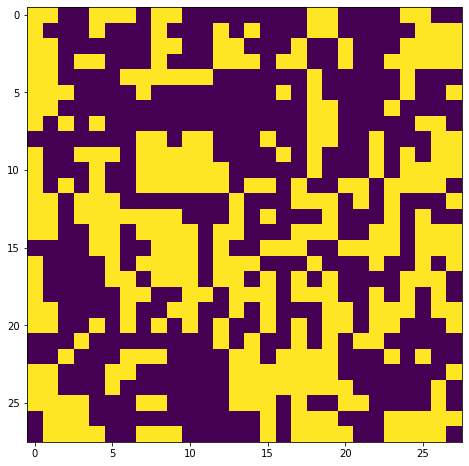

In [29]:
plt.imshow(np.squeeze(perturbations[0]))

In [30]:
def display_images(image, description, model):
  #_, label, confidence = get_imagenet_label(model_01.predict(image))
  _, label, confidence = get_imagenet_label(model.predict(image))
  plt.figure()
  #plt.imshow(image[0])
  plt.imshow(np.squeeze(image[0]))
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

In [31]:
epsilons = [0, 0.025, 0.05, 0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

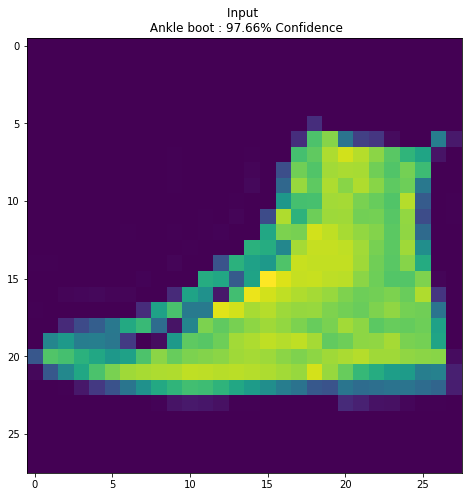

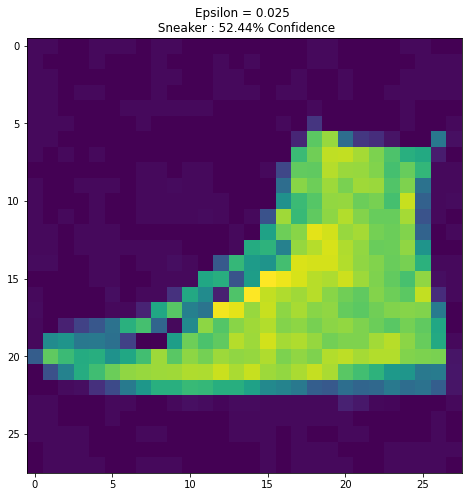

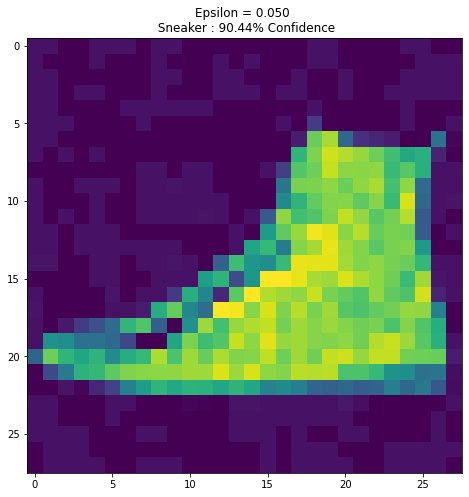

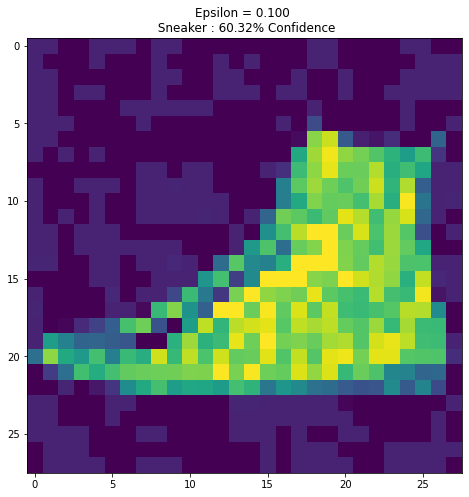

In [32]:
# empty array
adv_x_arr = [] 
for i, eps in enumerate(epsilons):
  adv_x = image_tf_a + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i], model_01)
  adv_x_arr.append(adv_x)

## Data augmentation
Modificamos las imagenes de entrenamiento aleatoriamente para poseer mayor cantidad de datos de entrenamiento. Transformaciones:zoom, rotár, ajuste de medidas y flip horizontal. 

In [38]:
# Parametro de data argumentation
shift_fraction=0.005
# Data argumentation
datagen = ImageDataGenerator(
        #rotation_range=20,
        width_shift_range= shift_fraction,
        height_shift_range= shift_fraction,
        shear_range=0.5,
        zoom_range=(0.9, 1.1),
        horizontal_flip=True,
        vertical_flip=False, 
        #fill_mode='constant',
        #cval=0
)



In [39]:
batches = datagen.flow(x_train, y_train, batch_size=batch_size)


# Mejoras de la red

# MODEL_05  
Implementamos un modelo con una capa oculta extra y con más neuronas


In [54]:
model_05 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(1024, activation='relu'),
        
        keras.layers.Dense(512, activation='relu'),
        
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_05.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 128)      

In [55]:

model_05.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [56]:
start_time = time.time()
history_05 = model_05.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.4179 - acc: 0.8454 - val_loss: 0.3202 - val_acc: 0.8847
Epoch 2/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2793 - acc: 0.8969 - val_loss: 0.2892 - val_acc: 0.8938
Epoch 3/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2336 - acc: 0.9139 - val_loss: 0.2467 - val_acc: 0.9114
Epoch 4/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.2066 - acc: 0.9234 - val_loss: 0.2411 - val_acc: 0.9134
Epoch 5/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1857 - acc: 0.9313 - val_loss: 0.2051 - val_acc: 0.9268
Epoch 6/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1704 - acc: 0.9363 - val_loss: 0.2451 - val_acc: 0.9131
Epoch 7/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1566 - acc: 0.9418 - val_loss: 

## modelo_06  
Sumamos otra capa oculta, cambiando el numero de neuronas para observar nuevos resultados

In [63]:
model_06 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1024, activation='relu'),
        
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_06.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_8 (Batch (None, 13, 13, 128)      

In [64]:
model_06.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [65]:
start_time = time.time()
history_06 = model_06.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.5461 - acc: 0.8017 - val_loss: 0.3816 - val_acc: 0.8587
Epoch 2/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3441 - acc: 0.8771 - val_loss: 0.2840 - val_acc: 0.8966
Epoch 3/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2862 - acc: 0.8986 - val_loss: 0.2736 - val_acc: 0.9056
Epoch 4/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2526 - acc: 0.9107 - val_loss: 0.2331 - val_acc: 0.9147
Epoch 5/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.2286 - acc: 0.9182 - val_loss: 0.2261 - val_acc: 0.9189
Epoch 6/15
1875/1875 [==============================] - 32s 17ms/step - loss: 0.2105 - acc: 0.9253 - val_loss: 0.2609 - val_acc: 0.9133
Epoch 7/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1965 - acc: 0.9298 - val_loss: 

## Modelo 07 sigmoid

In [79]:
model_07 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(1024, activation='sigmoid'),
        
        keras.layers.Dense(512, activation='sigmoid'),
        
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_07.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_14 (Batc (None, 13, 13, 128)      

In [80]:
model_07.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [81]:
start_time = time.time()
history_07 = model_07.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.4021 - acc: 0.8545 - val_loss: 0.3239 - val_acc: 0.8801
Epoch 2/15
1875/1875 [==============================] - 29s 16ms/step - loss: 0.2706 - acc: 0.9011 - val_loss: 0.2617 - val_acc: 0.9031
Epoch 3/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2304 - acc: 0.9163 - val_loss: 0.2409 - val_acc: 0.9122
Epoch 4/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2043 - acc: 0.9250 - val_loss: 0.2426 - val_acc: 0.9127
Epoch 5/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1799 - acc: 0.9338 - val_loss: 0.2169 - val_acc: 0.9244
Epoch 6/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.1704 - acc: 0.9375 - val_loss: 0.2106 - val_acc: 0.9253
Epoch 7/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1550 - acc: 0.9434 - val_loss: 

## Modelo 08 sigmoid + dropout

In [83]:


model_08 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(1024, activation='sigmoid'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='sigmoid'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_08.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_18 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_19 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
batch_normalization_20 (Batc (None, 13, 13, 128)      

In [ ]:
model_08.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [85]:
start_time = time.time()
history_08 = model_08.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.4641 - acc: 0.8362 - val_loss: 0.3988 - val_acc: 0.8547
Epoch 2/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2952 - acc: 0.8947 - val_loss: 0.2589 - val_acc: 0.9082
Epoch 3/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2505 - acc: 0.9101 - val_loss: 0.2351 - val_acc: 0.9135
Epoch 4/15
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2205 - acc: 0.9210 - val_loss: 0.2558 - val_acc: 0.9038
Epoch 5/15
1875/1875 [==============================] - 31s 16ms/step - loss: 0.1969 - acc: 0.9288 - val_loss: 0.2110 - val_acc: 0.9272
Epoch 6/15
1875/1875 [==============================] - 31s 17ms/step - loss: 0.1801 - acc: 0.9354 - val_loss: 0.2140 - val_acc: 0.9216
Epoch 7/15
1875/1875 [==============================] - 33s 18ms/step - loss: 0.1670 - acc: 0.9397 - val_loss: 

## Modelo 09 sigmoid y relu

In [95]:
model_09 = tf.keras.Sequential([
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(28, 28, 1)),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),

        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),        
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv2D(512, kernel_size=(3, 3), activation='relu'),
        keras.layers.BatchNormalization(),    
        keras.layers.MaxPooling2D(pool_size=(2, 2)),   
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(512, activation='relu'),
        #keras.layers.Dropout(0.5),
        keras.layers.Dense(512, activation='sigmoid'),
        #keras.layers.Dropout(0.5),
        keras.layers.Dense(1024, activation='sigmoid'),
        
        keras.layers.Dense(10, activation='softmax')
    ])
# Take a look at the model summary
model_09.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_30 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_31 (Batc (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 13, 256)       147712    
_________________________________________________________________
batch_normalization_32 (Batc (None, 13, 13, 256)      

In [96]:
model_09.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Adamax(lr=learning_rate),
              metrics=['acc'])

In [97]:
start_time = time.time()
history_09 = model_09.fit(
    batches,
    validation_data=(x_test, y_test),
    workers=10,
    steps_per_epoch = steps_per_epoch,
    epochs=epoch,
    
)
print("--- %s seconds ---" % (time.time() - start_time))

  ...
    to  
  ['...']
Train for 1875 steps, validate on 10000 samples
Epoch 1/15
1875/1875 [==============================] - 62s 33ms/step - loss: 0.4156 - acc: 0.8494 - val_loss: 0.3110 - val_acc: 0.8874
Epoch 2/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2753 - acc: 0.9005 - val_loss: 0.2344 - val_acc: 0.9146
Epoch 3/15
1875/1875 [==============================] - 63s 33ms/step - loss: 0.2299 - acc: 0.9149 - val_loss: 0.2418 - val_acc: 0.9126
Epoch 4/15
1875/1875 [==============================] - 60s 32ms/step - loss: 0.2015 - acc: 0.9260 - val_loss: 0.3100 - val_acc: 0.8820
Epoch 5/15
1875/1875 [==============================] - 61s 32ms/step - loss: 0.1818 - acc: 0.9333 - val_loss: 0.2177 - val_acc: 0.9205
Epoch 6/15
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1622 - acc: 0.9395 - val_loss: 0.2116 - val_acc: 0.9256
Epoch 7/15
1875/1875 [==============================] - 58s 31ms/step - loss: 0.1454 - acc: 0.9465 - val_loss: 

# Adversary Attack en modelos  Objetivos
Utilizamos las imagenes generadas con la tecnica FGSM a partir del modelo sustituto para atacar como caja negra los modelos del 05 al 09


### Atacando al modelo 05

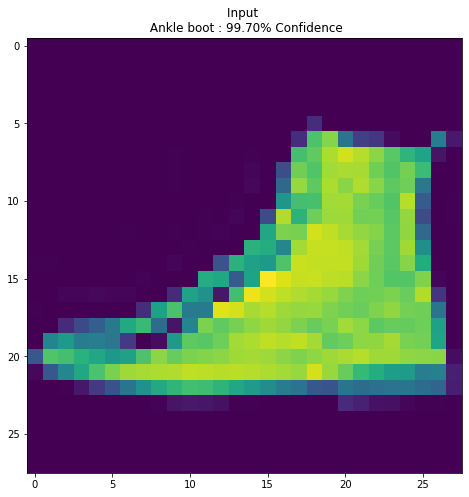

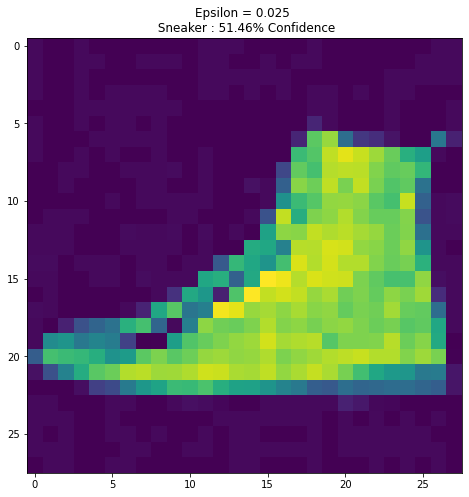

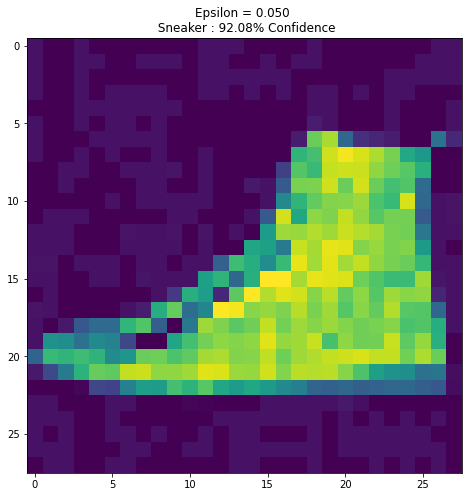

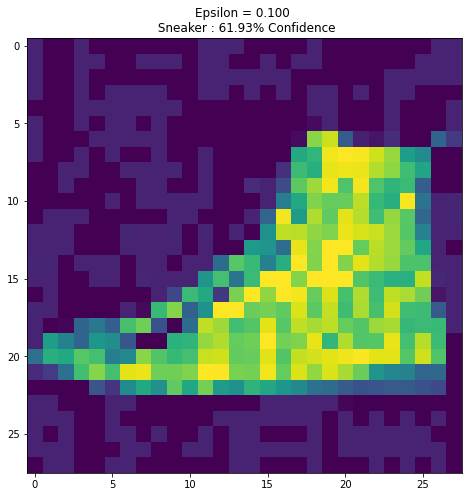

In [100]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_05)
  

### Atacando al modelo 06

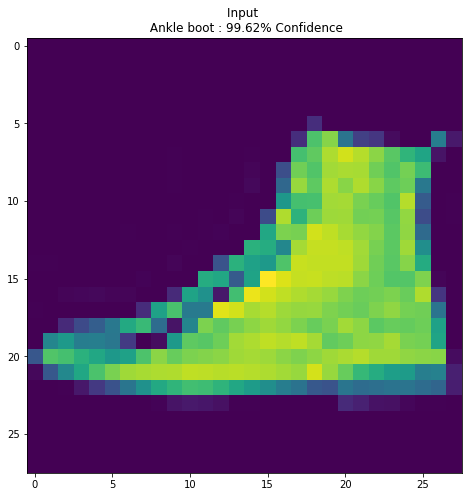

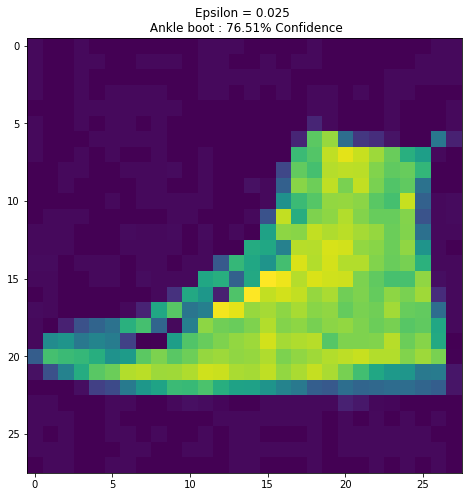

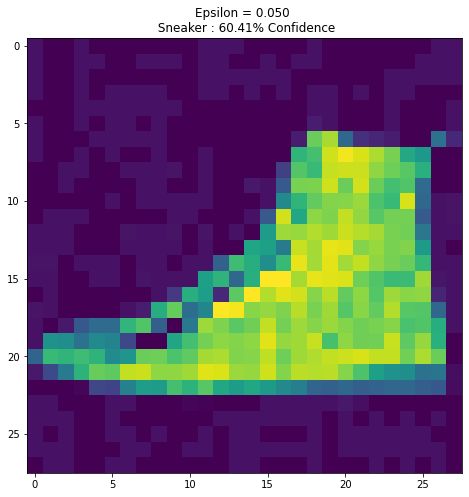

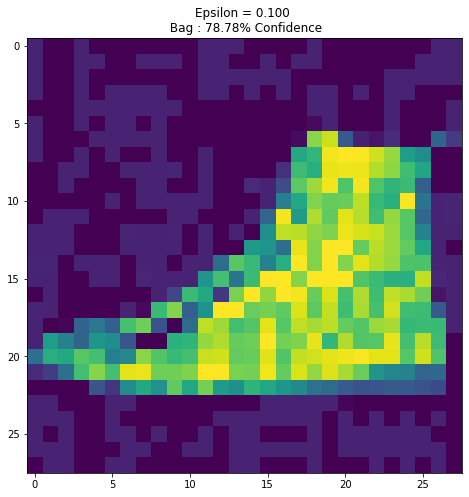

In [88]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_06)

### Atacando al modelo 07

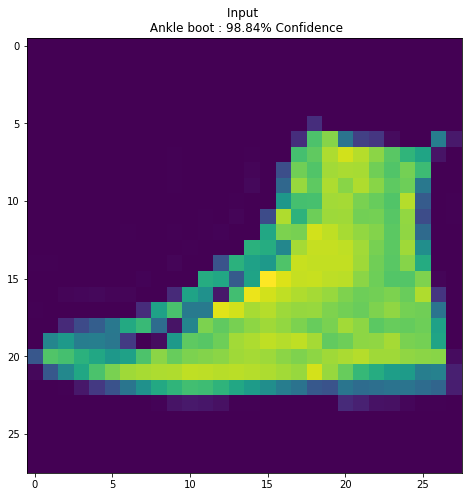

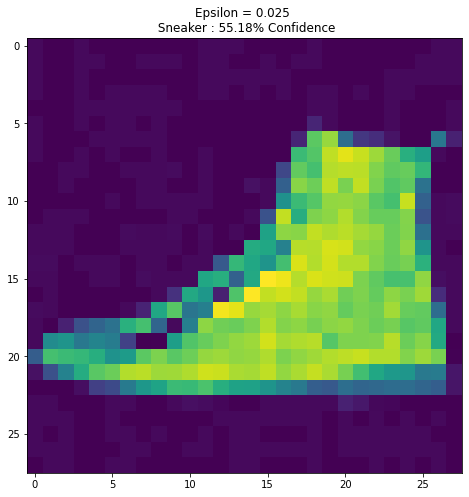

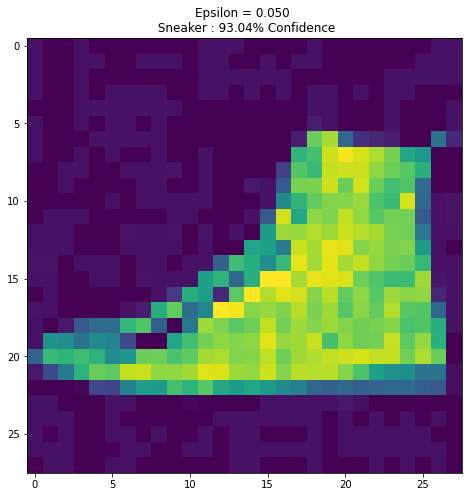

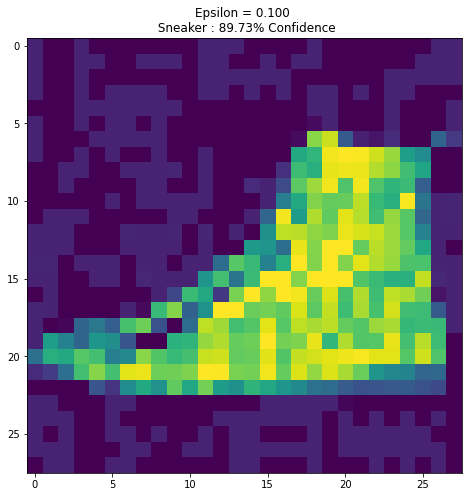

In [89]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_07)

### Atacando al modelo 08

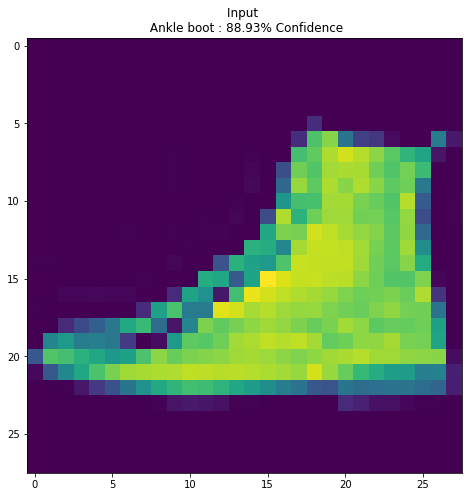

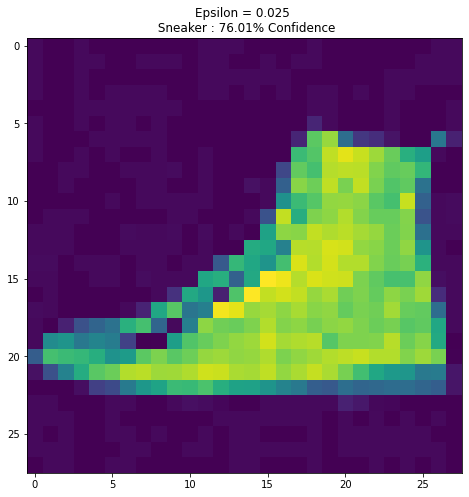

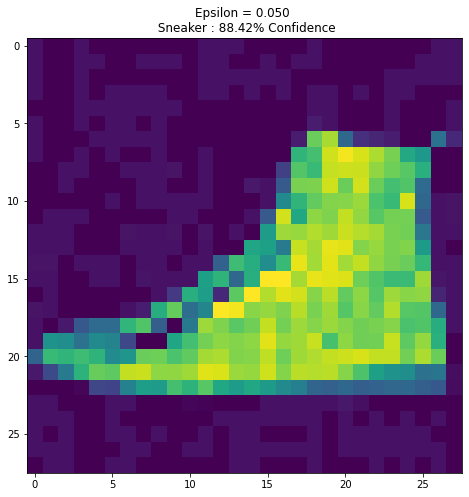

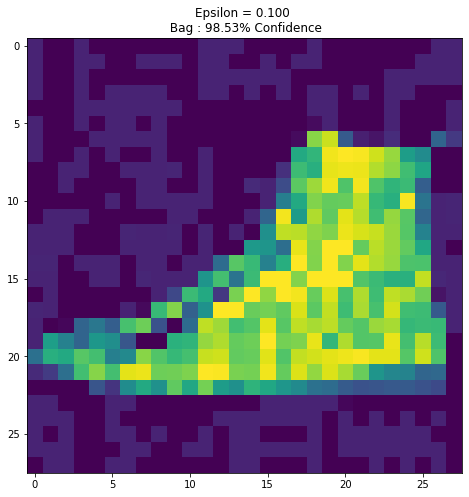

In [90]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_08)

### Atacando al modelo 09

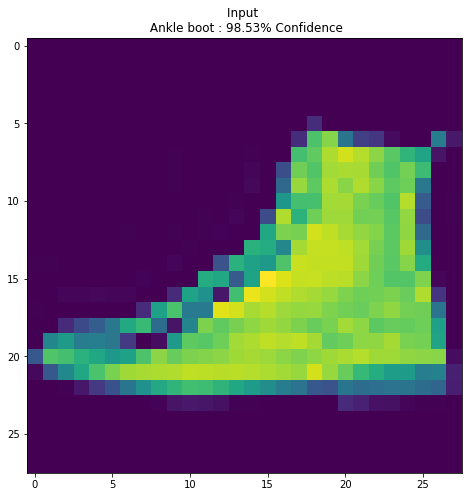

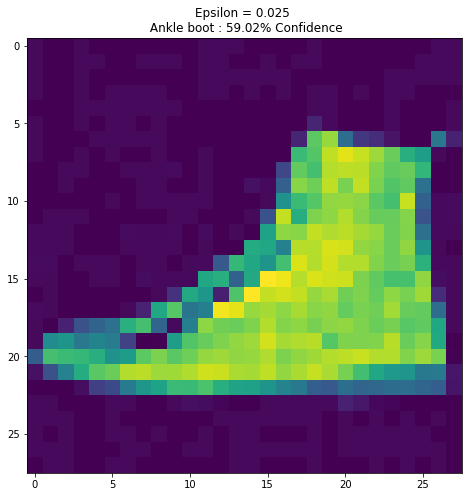

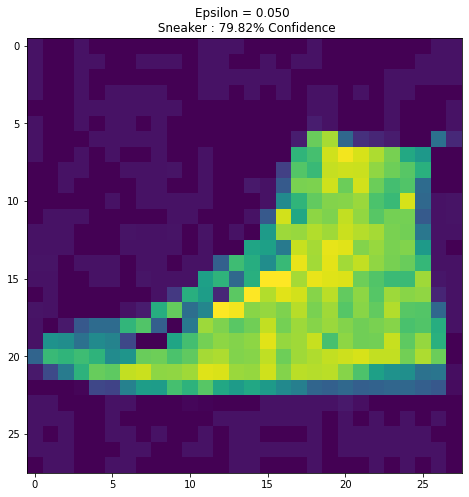

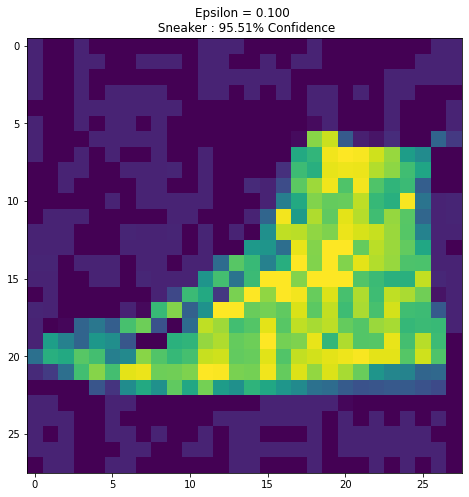

In [99]:
for i in range(len(adv_x_arr)):
    display_images(adv_x_arr[i], descriptions[i], model_09)

# Resultados  
Se comprueba la propiedad de transferibilidad de imágenes adversarias generadas en un modelo sustituto creado  para atacar a otros modelos a los cuales solo se accede como caja negra.


![resultado](resultados.png)

Cada modelo posee distintas cantidad de capas, neuronas, funciones de activación, algunas usan dropout otras no, data argumentation (con excepción del modelo sustituto). Se observa como los cinco modelos numerados del 05 al 09 clasificaron erróneamente la entrada para epsilon a partir de 0.05. Un epsilon menor solo hizo fallar a 3 de los 5 modelos. Los pequeños epsilon generan una perturbación que es imperceptible para el ojo humano.


## Random attack

In [36]:
#perturbations_random=np.squeeze(perturbations)
#print(np.squeeze(perturbations[0]))
#print(perturbations_random)
perturbations_rand = np.zeros((1, 28, 28, 1))
for i in range(28):
    for j in range(28):
        perturbations_rand[0][i][j][0] = choice([-1.0, 0.0, 1.0])
#print(np.squeeze(perturbations_rand[0]))

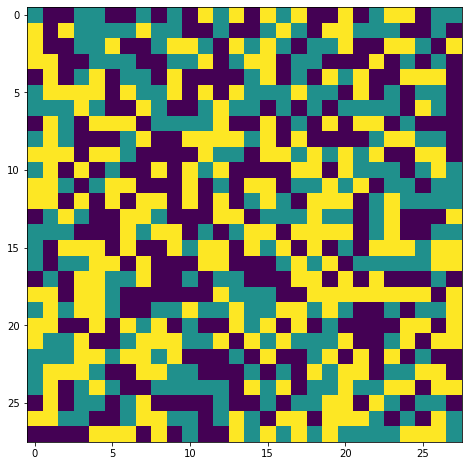

In [34]:
plt.imshow(np.squeeze(perturbations_rand[0]))

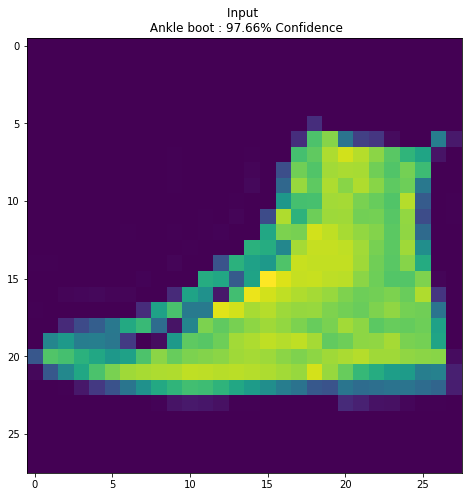

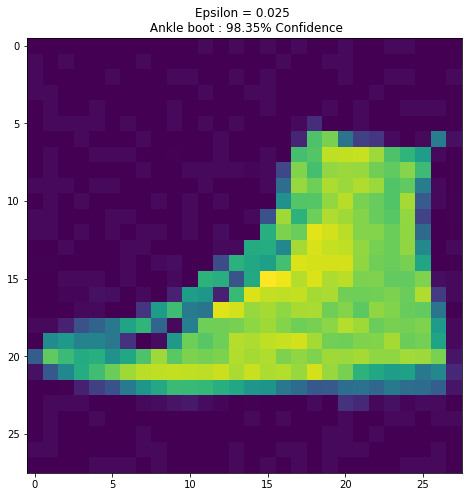

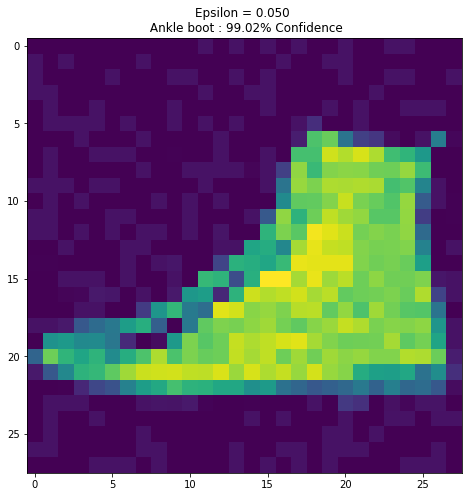

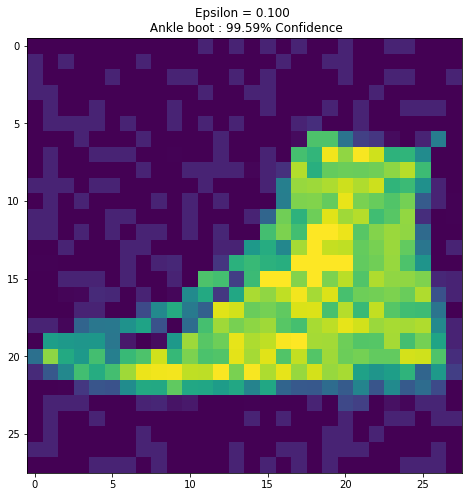

In [35]:
# empty array
adv_x_arr_rand = [] 
for i, eps in enumerate(epsilons):
  adv_x = image_tf_a + eps*perturbations_rand
  adv_x = tf.clip_by_value(adv_x, 0, 1)
  display_images(adv_x, descriptions[i], model_01)
  adv_x_arr_rand.append(adv_x)